Crameri-Tackley model
=======

From Cramer and Tackley 2015
--------






References
====




Load python functions needed for underworld. Some additional python functions from os, math and numpy used later on.

In [1]:
import networkx as nx
import underworld as uw
import math
from underworld import function as fn
import glucifer
#import matplotlib.pyplot as pyplot
import time
import numpy as np
import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import collections
import slippy2 as sp

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [2]:
#Display working directory info if in nb mode
if (len(sys.argv) > 1):
    if (sys.argv[1] == '-f'):
        !pwd && ls
        

/Users/dansandiford/Documents/programming/earthsci_code/python/crustyconvection/stickyairtests
base_model.ipynb


In [3]:
############
#Model name.  
############
Model = "T"
ModNum = 2

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])

Set physical constants and parameters, including the Rayleigh number (*RA*). 

In [4]:
###########
#Standard output directory setup
###########


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" + str(ModIt) + "/"
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '_' + str(ModIt) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
        
comm.Barrier() #Barrier here so not procs run the check in the next cell too early 

In [5]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False
        


results/T/2/Base/checkpoint/ is empty


In [51]:
###########
#Physical parameters
###########

#The Slippy rheology class will contain dimensional and nondimensional values, linked in a self-consistent way by scaling paramters
#lowermantle.nondimensional['cohesion']
#Where lowermantle is a material class (generated within a rheology class); and non dimensional is a dictionary

#UW naming conventions: 
#module_name, package_name, ClassName, function_name, method_name, 
#ExceptionName, propertyName GLOBAL_CONSTANT_NAME, globalVarName, instanceVarName, functionParameterName, localVarName
###########


#dimensional parameter dictionary
dp = edict({'LS':2890.*1e3,
           'rho':3300,
           'g':9.81, 
           'eta0':1e23,
           'k':10**-6,
           'a':1.25*10**-5, 
           'TS':273.,
           'TB':2773.,
           'deltaT':2500, 
           'cohesion':1e7, 
           'E':240000., 
           'R':8.314,
           'V':6.34*(10**-7),
           'StALS': 150e3})

#non-dimensional parameter dictionary
#One draw back of a dictionary structure, is that variables cannot link to other variables
RAfac = 1.
ndp = edict({'RA':1e6*RAfac,      
              'LS':1.,
              'eta0':1.,
              'StAeta0':1e-2,
              'k':1.,
              'E':11.55,
              'V':3.0,
              'H':20.,
              'TR':(1600./2500.),
              'TS':(dp.TS/2500.),
              'RD':1.,
              'cohesion':1577.*RAfac,
              'cohesion_reduce':10.,
              'fc':0.1, 
              'low_visc':RAfac*1e-4,
              'up_visc':1e5,
              'random_temp': 0.05})


#A few parameters defining lengths scales, affects materal transistions etc.
MANTLETOCRUST = (18.*1e3)/dp.LS #Crust depth
CRUSTTOMANTLE = (300.*1e3)/dp.LS 
LITHTOMANTLE = (660.*1e3)/dp.LS 
MANTLETOLITH = (200.*1e3)/dp.LS 
TOPOHEIGHT = (15.*1e3)/dp.LS  #rock-air topography limits
AVGTEMP = 0.53 #Used to define lithosphere


#Compositional Rayliegh number of rock-air
ETAREF = dp.rho*dp.g*dp.a*dp.deltaT*((dp.LS)**3)/(ndp.RA*dp.k) #equivalent dimensional reference viscosity
RC = (3300.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
COMP_RA_FACT = RC/ndp.RA


#Additional dimensionless paramters

ndp["StA"] = ndp.RA*COMP_RA_FACT


#######################To be replaced soon
#Physical parameters that can be defined with STDIN,
#The == '-f': check is a a hack check to see cover the notebook case
if len(sys.argv) == 1:
    ndp.cohesion = ndp.cohesion
elif sys.argv[1] == '-f':
    ndp.cohesion = ndp.cohesion
else:
    ndp.cohesion = float(sys.argv[1])*newvisc

In [16]:
###########
#Model setup parameters
###########

stickyAir = False

MINX = -1.
MINY = 0.
MAXX = 1.0

#MAXY = 1.035
MAXY = 1.

if MINX == 0.:
    squareModel = True
else: 
    squareModel = False
    
    
dim = 2          # number of spatial dimensions


#MESH STUFF

RES = 128

if MINX == 0.:
    Xres = RES
else:
    Xres = 2*RES

if stickyAir:
    Yres = RES
    MAXY = 1. + dp.StALS/dp.LS #150km
    
else:
    Yres = RES
    MAXY = 1.


periodic = [False,True]
elementType = "Q1/dQ0"
#elementType ="Q2/DPC1"

refineMesh = False

s = 1.2 #Mesh refinement parameter
ALPHA = 11. #Mesh refinement parameter

#System/Solver stuff

PIC_integration=False

In [17]:
###########
#Model Runtime parameters
###########

swarm_update = 1
swarm_repop = 5
files_output = 1e6
gldbs_output = 1
images_output = 1e6
checkpoint_every = 25
metric_output = 1
sticky_air_temp = 1

comm.Barrier() #Barrier here so not procs run the check in the next cell too early 

assert metric_output <= checkpoint_every, 'Checkpointing should run less or as ofen as metric output'
assert (metric_output >= swarm_update), 'Swarm update is needed before checkpointing'
assert metric_output >= sticky_air_temp, 'Sticky air temp should be updated more frequently that metrics'


In [18]:
###########
#Model output parameters
###########

#Do you want to write hdf5 files - Temp, RMS, viscosity, stress?
writeFiles = True
loadTemp = True


In [19]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX,MINY), 
                                 maxCoord=(MAXX,MAXY), periodic=periodic)



velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [20]:
print("mesh size", mesh.data.shape, mesh.elementRes)

('mesh size', (33153, 2), (256, 128))


In [21]:
Xres, Yres, MINX,MAXX,MINY,MAXY, periodic, elementType, dim 

(256, 128, -1.0, 1.0, 0.0, 1.0519031141868511, [False, False], 'Q1/dQ0', 2)

##Refine mesh

In [23]:
#X-Axis

if refineMesh:
    mesh.reset()
    axis = 0
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (abs(mesh.maxCoord[axis]) - abs(mesh.minCoord[axis]))/2.
    el_reduction = 0.5001
    dx = mesh.maxCoord[axis] - min_point

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction) *deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    sp.deform_1d(deform_lengths, mesh,axis = 'x',norm = 'Min', constraints = [])

Min
(256, 0.0039070312499999999, 1.5001999999999998, 0.99960000000000093)
('edges', 256)
-- iteration 0 --
| F( p_n ) |^2: 3.09820187569e-05
| p_n+1 - p_n |^2: 2.13378167966
-- iteration 1 --
| F( p_n ) |^2: 9.51252910719e-31
Min, Max element width: 
0.00391
0.01172


In [24]:
#Y-Axis
if refineMesh:
    #Y-Axis
    axis = 1
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (mesh.maxCoord[axis])
    el_reduction = 0.5
    dx = mesh.maxCoord[axis]

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction)*deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    sp.deform_1d(deform_lengths, mesh,axis = 'y',norm = 'Min', constraints = [])

Min
(128, 0.0041089965397923195, 0.78687283737024227, 1.0157480314960283)
('edges', 128)
-- iteration 0 --
| F( p_n ) |^2: 3.4299480012e-05
| p_n+1 - p_n |^2: 1.19892689066
-- iteration 1 --
| F( p_n ) |^2: 5.98648239823e-31
Min, Max element width: 
0.00411
0.01233



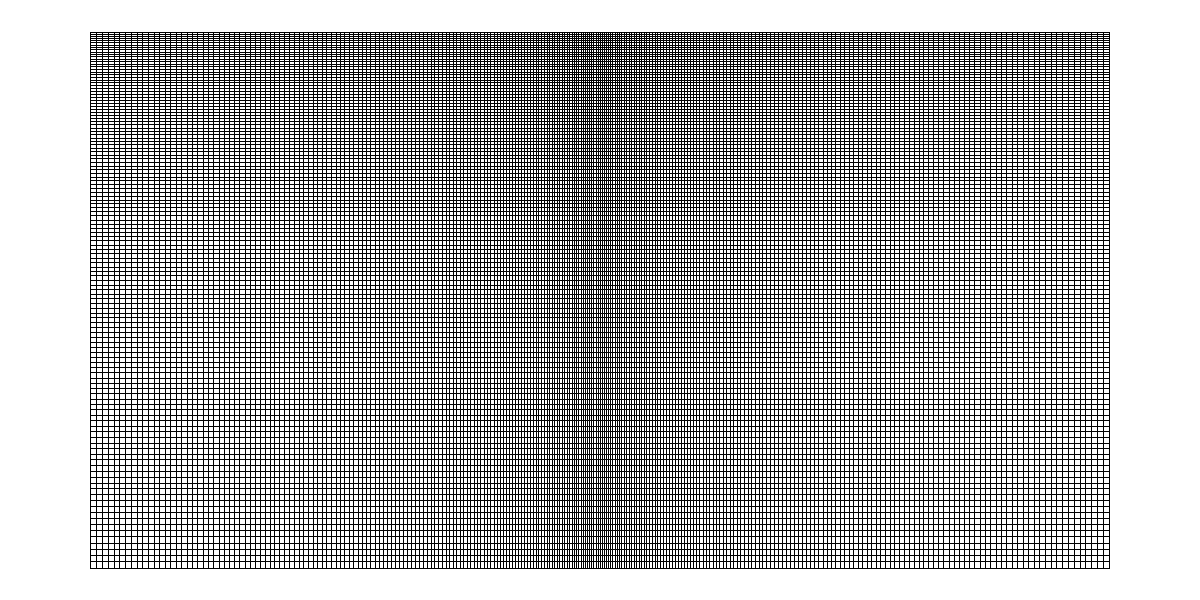

In [25]:
figMesh = glucifer.Figure(figsize=(1200,600),antialias=1)
#figMesh.append( glucifer.objects.Mesh(mesh.subMesh, nodeNumbers=True) )
figMesh.append( glucifer.objects.Mesh(mesh) )
figMesh.show()

# ICs and BCs

In [26]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
# send boundary condition information to underworld
IWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
JWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
TWalls = mesh.specialSets["MaxJ_VertexSet"]
BWalls = mesh.specialSets["MinJ_VertexSet"]
AWalls = IWalls + JWalls

In [27]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.
temperatureDotField.data[:] = 0.

def wbl(x, w0 = 0.06):
    delx = 1- abs(x)
    Wbl = w0*math.sqrt(delx)
    if Wbl== 0.: #to avoid division by zero
        Wbl = 1e-8
    return Wbl


def tempf(z,w,t0=0.64):
    temp = t0*math.erf((1-z)/w)
    return temp



In [28]:
age_asymmetry = 2.

for index, coord in enumerate(mesh.data):
    if coord[0] > 0.:
        w = wbl(coord[0])
        t = tempf(coord[1], w)
        temperatureField.data[index] = t
    else:
        w = wbl(coord[0])/age_asymmetry
        t = tempf(coord[1], w)
        temperatureField.data[index] = t
        


for index, coord in enumerate(mesh.data):
    if abs(coord[0]) < wbl(0)/2. and coord[1] > 0.5:
        w = wbl(0)/2.
        d = w - abs(coord[0])
        t = tempf(d, coord[1], w)
        temperatureField.data[index] = t
        
        

#Set sticky air Temp to zero
for index, coord in enumerate(mesh.data):
    if coord[1] > 1.:
        temperatureField.data[index] = 0.

In [29]:
#For notebook runs
#ModIt = "96"

In [30]:
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = (TWalls, JWalls) )

# also set dirichlet for temp field
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(JWalls,) )


# set initial conditions (and boundary values)
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.






##Add Random 125 K temp perturbation


In [31]:
tempNump = temperatureField.data

#In gerneral we only want to do this on the initial setup, not restarts
#Takes an input from the ndp dictionary: ndp.random_temp



if not checkpointLoad:
    for index, coord in enumerate(mesh.data):
        pertCoeff = (ndp.random_temp*(np.random.rand(1)[0] - 0.5)) #this should create values between [-0.5,0.5] from uniform dist.
        ict = tempNump[index]
        tempNump[index] = ict + pertCoeff

##Reset bottom Dirichlet conds.

In [32]:
# Set temp boundaries 
# on the boundaries
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TR
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TS

In [33]:
#temperatureField.evaluate(IWalls).min()

#Particles

In [34]:
###########
#Material Swarm and variables
###########

gSwarm = uw.swarm.Swarm(mesh=mesh)
materialVariable = gSwarm.add_variable( dataType="char", count=1 )
rockIntVar = gSwarm.add_variable( dataType="double", count=1 )
airIntVar = gSwarm.add_variable( dataType="double", count=1 )
lithIntVar = gSwarm.add_variable( dataType="double", count=1 )

varlist = [materialVariable, rockIntVar, airIntVar, lithIntVar]
varnames = ['materialVariable', 'rockIntVar', 'airIntVar', 'lithIntVar']

In [35]:
###########
#Swarms for surface intragrals when using Sticky air
###########

snum = 1000.
dx = (mesh.data[:,0].max()- mesh.data[:,0].min())/snum
yp = 0.9947 #1. - yelsize/2. at res = 96

mesh.data[:,0].max()
xps = np.linspace(mesh.data[:,0].min(),mesh.data[:,0].max(), snum)
yps = [yp for i in xps]

surfintswarm = uw.swarm.Swarm( mesh=mesh )
dumout = surfintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

yps = [ 1.- yp  for i in xps]

baseintswarm = uw.swarm.Swarm( mesh=mesh)
dumout = baseintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

#Initialise swarm variables, or Swarm checkpoint load

In [36]:
mantleIndex = 0
lithosphereIndex = 1
crustIndex = 2
airIndex = 3


if checkpointLoad:
    checkpointLoadDir = natsort.natsorted(checkdirs)[-1]
    temperatureField.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField.load(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField.load(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    gSwarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    # Create the layout object
    #layout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=gSwarm, particlesPerCell=20)
    #layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=15)
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=25)
    # Now use it to populate.
    gSwarm.populate_using_layout( layout=layout )

    # Lets initialise the 'materialVariable' data to represent different materials
    # Set the material to heavy everywhere via the numpy array
    materialVariable.data[:] = mantleIndex
    
    
    #Set initial air and crust materials (allow the graph to take care of lithsophere)
    #########
    #This initial material setup will be model dependent
    #########
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (1. - gSwarm.particleCoordinates.data[particleID][1]) < 0:
                 materialVariable.data[particleID] = airIndex
        elif (1. - gSwarm.particleCoordinates.data[particleID][1]) < MANTLETOCRUST:
                 materialVariable.data[particleID] = crustIndex

#Material Graphs

In [37]:
##############
#Important: This is a quick fix for a bug that arises in parallel runs
##############
material_list = [0,1,2,3]


In [38]:
print( "unique values after swarm has loaded:" + str(np.unique(materialVariable.data[:])))


unique values after swarm has loaded:[0 2 3]


In [39]:


#All depth conditions are given as (km/D) where D is the length scale, 
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

#######Graph object
DG = nx.DiGraph(field="Depth")

#######Nodes
#Note that the order of materials, deepest to shallowest is important 
DG.add_node(0, mat='mantle')
DG.add_node(1, mat='lithosphere')
DG.add_node(2, mat='crust')
DG.add_node(3, mat='air')


labels=dict((n,d['mat']) for n,d in DG.nodes(data=True))
pos=nx.spring_layout(DG) 


#######Edges
#anything to air
DG.add_edges_from([(0,3),(1,3), (2,3)])
DG[0][3]['depthcondition'] = -1*TOPOHEIGHT
DG[1][3]['depthcondition'] = -1*TOPOHEIGHT
DG[2][3]['depthcondition'] = -1*TOPOHEIGHT


#Anything to mantle
DG.add_edges_from([(2,0), (3,0), (1,0)])
DG[3][0]['depthcondition'] = TOPOHEIGHT
DG[2][0]['depthcondition'] = CRUSTTOMANTLE
DG[1][0]['depthcondition'] = LITHTOMANTLE #This means we're going to kill lithosphere at the 660.


#Anything to lithsphere
DG.add_edges_from([(0,1),(3,1)])
DG[0][1]['depthcondition'] = MANTLETOLITH
DG[0][1]['avgtempcondition'] = 0.75*AVGTEMP #definition of thermal lithosphere


#Anything to crust
DG.add_edges_from([(0,2), (1,2)])
DG[0][2]['depthcondition'] = MANTLETOCRUST
DG[1][2]['depthcondition'] = MANTLETOCRUST

In [40]:
DG.nodes()

[0, 1, 2, 3]

In [41]:
remove_nodes = []
for node in DG.nodes():
    if not node in material_list:
        remove_nodes.append(node)
        
for rmnode in remove_nodes:
    DG.remove_node(rmnode)

In [42]:
DG.nodes()

[0, 1, 2, 3]

In [43]:

#remove_nodes = []
#for node in DG.nodes_iter():
#    if not node in material_list:
#        remove_nodes.append(node)
        
#for rmnode in remove_nodes:
#    DG.remove_node(rmnode)

In [44]:
#A Dictionary to map strings in the graph (e.g. 'depthcondition') to particle data arrays

particledepths = 1. - gSwarm.particleCoordinates.data[:,1]
particletemps = temperatureField.evaluate(gSwarm)[:,0]

conditionmap = {}

conditionmap['depthcondition'] = {}
conditionmap['depthcondition']['data'] = particledepths
conditionmap['avgtempcondition'] = {}
conditionmap['avgtempcondition']['data'] = particletemps

In [45]:
def update_swarm(graph, particleIndex):
    """
    This function takes the materials graph (networkx.DiGraph), and a particle index,
    then determines if a material update is required 
    and if so, returns the new materialindex
    Args:
        graph (networkx.DiGraph): Directed multigraph representing the transformation of material types
        particleIndex (int): the particle index as corressponding to the index in the swarm data arrays
    Returns:
        if update is required the function returns the the new material variable (int) 
        else returns None
    Raises:
        TypeError: not implemented
        ValueError: not implemented
    """
    ##Egde gives links to other materials, we then query the conditions to see if we should change materials
    matId = materialVariable.data[particleIndex][0]
    innerchange = False
    outerchange = False
    for edge in graph[matId]:
        if outerchange:
            break
        for cond in graph[matId][edge].keys():
            outerchange = False
            if innerchange: #found a complete transition, break inner loop
                break
            currentparticlevalue = conditionmap[cond]['data'][particleIndex]
            crossover = graph[matId][edge][cond]
            if ((matId > edge) and (currentparticlevalue > crossover)):
                innerchange = False # continue on, 
                if graph[matId][edge].keys()[-1] == cond:
                    outerchange = True
                    innerchange = edge
                    break
            elif ((matId < edge) and (currentparticlevalue < crossover)):
                innerchange = False
                if graph[matId][edge].keys()[-1] == cond:
                    outerchange = True
                    innerchange = edge
                    break
            else:
                #condition not met, break outer loop, go to next edge, outerchange should still be False
                break
    if type(innerchange) == int:
        return innerchange

In [46]:
#fn.branching.conditional?

In [47]:
#Cleanse the swarm of its sins
#For some Material Graphs, the graph may have to be treaversed more than once

check = -1
number_updated = 1

while number_updated != 0:
    number_updated = 0
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
                check = update_swarm(DG, particleID)
                if check > -1:
                    number_updated += 1
                    materialVariable.data[particleID] = check

In [48]:
## Here we'll play around with some different crust-perturbations
##Voul inlude this is the Graph update function, but for now keep it seperate

#MANTLETOCRUST
centre = 0.0
#CRUSTTOMANTLE

square_shape = np.array([ (MANTLETOCRUST ,1. ), (-1.*MANTLETOCRUST ,1. ), ((-1.*MANTLETOCRUST) , 
                       (1.0 - CRUSTTOMANTLE/2.) ), ((MANTLETOCRUST),(1.0 - CRUSTTOMANTLE/2.))])
square_shape = fn.shape.Polygon( square_shape)

sub_zone1 = np.array([ ((2*MANTLETOCRUST + 0.5*MANTLETOLITH),1. ), ((-2.*MANTLETOCRUST + 0.5*MANTLETOLITH) ,1. ), 
                     ((-2.*MANTLETOCRUST - 0.5*MANTLETOLITH ) ,(1.0 - CRUSTTOMANTLE/2.) ), ((2*MANTLETOCRUST - 0.5*MANTLETOLITH ),(1.0 - CRUSTTOMANTLE/2. )) ])
shape1 = fn.shape.Polygon( sub_zone1)


if not checkpointLoad:
    for particleID in range( gSwarm.particleCoordinates.data.shape[0] ):
        if shape1.evaluate(tuple(gSwarm.particleCoordinates.data[particleID])):
    #        #print "true"
            materialVariable.data[particleID] = crustIndex
        #elif shape2.evaluate(tuple(gSwarm.particleCoordinates.data[particleID])):
        #    materialVariable.data[particleID] = crustIndex


In [49]:
#shape.evaluate(


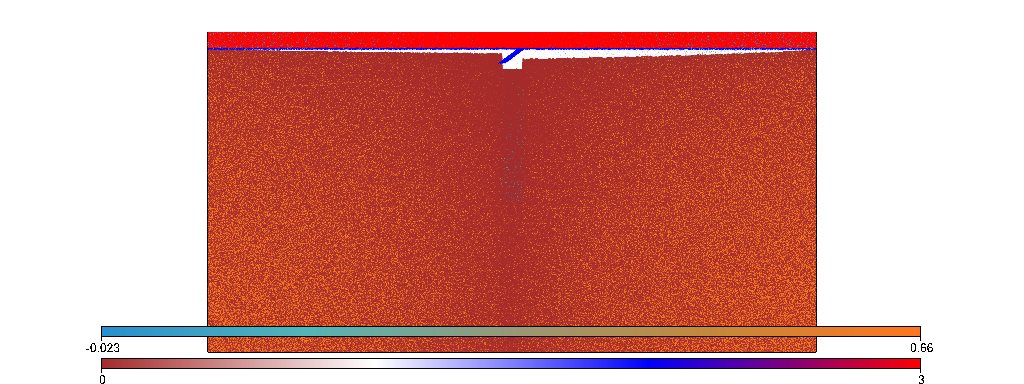

In [50]:
figSwarm = glucifer.Figure(figsize=(1024,384))
figSwarm.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red'))
#figSwarm.append( glucifer.objects.Mesh(mesh))
figSwarm.append( glucifer.objects.Surface(mesh, temperatureField))
figSwarm.save_database('test.gldb')
figSwarm.show()

## Set the values for the masking swarms

In [53]:
#Setup up a masking Swarm variable for the integrations.
#These should be rebuilt at same frequency as the metric calcualtions

rockIntVar.data[:] = 0.
notair = np.where(materialVariable.data != airIndex)
rockIntVar.data[notair] = 1.

airIntVar.data[:] = 0.
notrock = np.where(materialVariable.data == airIndex)
airIntVar.data[notrock] = 1.

lithIntVar.data[:] = 0.
islith = np.where((materialVariable.data == lithosphereIndex) | (materialVariable.data == crustIndex))
lithIntVar.data[islith] = 1.

#Material properties


In the paper, Crameri and Tackley give the dimensionless cohesion as well as the dimensionless yield stress gradient. But the latter is given as a function of dimensionless (lithostatic) pressure, whereas it is easier to use dimensionless depth. Easy, multiply the dimensionless depth by $\rho g D$, divide by the stress scale, $\frac{\eta \kappa}{D^2}$ then use the same dimensionless yeild stress gradient ($\mu$)

In [54]:
# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))


coordinate = fn.input()
depth = 1. - coordinate[1]

#Determine yield criterion for depth (rather than pressure as given in Crameri)
#Scaling is same as van Heck and Tackley, EPSL, 2011
lithopressuregrad = dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k)

In [55]:
#Check important paramters
print(ndp.E, ndp.V,ndp.TS,ndp.RD, ndp.TR, ndp.cohesion)

(11.55, 3.0, 0.1092, 1.0, 0.64, 15770.0)


In [56]:
#ndp.up_visc/ndp.low_visc

In [57]:
############
#Mantle
############

#Linear viscosity
arhennius = fn.misc.min(ndp.up_visc,fn.math.exp(((ndp.E + ndp.V*(1.-coordinate[1]))/
                                         (temperatureField + ndp.TS)) - ((ndp.E + ndp.V*(1.- ndp.RD))/(ndp.TR + ndp.TS))))

#Psuedo-plastic 
ys =  ndp.cohesion + (depth*ndp.fc*lithopressuregrad)
#ys =  ndp.fc*lithopressuregrad*(30e3/dp.LS) # this is the byerlee strength at 30 km
yss = fn.misc.max(ndp.cohesion, ys)
plasticvisc = yss*(math.sqrt(2))/(strainRate_2ndInvariant*2.)
plastic = fn.misc.max(ndp.low_visc,plasticvisc)
#combine these
mantleviscosityFn = fn.exception.SafeMaths(fn.misc.min(arhennius, plastic))

############
#crust
############



ysc = (ndp.cohesion/ndp.cohesion_reduce) + (depth*(ndp.fc/100.)*lithopressuregrad)
#ysc = ys/100.
ycs = fn.misc.max((ndp.cohesion/ndp.cohesion_reduce), ysc)
crustplasticvisc = ycs*(math.sqrt(2))/(strainRate_2ndInvariant*2.)
crustplastic = fn.misc.max(ndp.low_visc,crustplasticvisc) 
crustviscosityFn = fn.exception.SafeMaths(fn.misc.min(arhennius, crustplastic))

Note that the rheology implemented manually above can also be set up using an Underworld2 function, as follows:
```python
fn_stress =  2.*arhennius*uw.function.tensor.symmetric(velocityField.fn_gradient )
plasticvisc = fn.rheology.stress_limiting_viscosity(fn_stress,ys,arhennius)
plastic = fn.misc.max(1e-4,plasticvisc)
mantleviscosityFn = fn.exception.SafeMaths(fn.misc.min(arhennius, plastic))
stokesPIC.fn_viscosity = mantleviscosityFn
```

Set up material properties
====

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

In [58]:
# Here we set a viscosity value of '1.' for both materials
viscosityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StAeta0, 
                                    lithosphereIndex:mantleviscosityFn, 
                                    crustIndex:crustviscosityFn,
                                    mantleIndex:mantleviscosityFn} )

densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StA, 
                                    lithosphereIndex:ndp.RA*temperatureField, 
                                    crustIndex:ndp.RA*temperatureField, 
                                    mantleIndex:ndp.RA*temperatureField} )

# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )

buoyancyFn = gravity*densityMapFn

Build the Stokes system, solvers, advection-diffusion
------

Setup linear Stokes system to get the initial velocity.

In [59]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               #swarm         = gSwarm, 
                               conditions    = [freeslipBC,],
                               fn_viscosity   = arhennius, 
                               fn_bodyforce   = buoyancyFn,
                               swarm=gSwarm)


In [60]:
#We do one solve with linear viscosity to get the initial strain rate invariant. 
#This solve step also calculates a 'guess' of the the velocity field based on the linear system, 
#which is used later in the non-linear solver.

solver = uw.systems.Solver(stokesPIC)
# If not doing a restart, do a solve on the non-plastic system
if not checkpointLoad:
    solver.solve()

In [61]:
solver.options

* CG
* 

In [62]:
print(solver.options.A11.list())
print(solver.options.scr.list())
print(solver.options.mg.list())
print(solver.options.mg_accel.list())
print(solver.options.main.list())
print(solver.options.rhsA11.list())
print(solver.options.backsolveA11.list())

('_mg_active', True)
('ksp_type', 'fgmres')
('ksp_rtol', 1e-05)
None
('_mg_active', True)
('ksp_type', 'fgmres')
('ksp_rtol', 1e-05)
None
('active', True)
('levels', 8)
None
('mg_smoothing_adjust_on_convergence_rate', False)
('mg_target_cycles_10fold_reduction', 5)
('mg_smooths_min', 2)
('mg_smooths_max', 200)
('mg_smoothing_increment', 1)
('mg_accelerating_smoothing', False)
('mg_smooths_to_start', 3)
('mg_smoothing_acceleration', 1.1)
None
('remove_constant_pressure_null_space', False)
('ksp_k2_type', 'NULL')
('change_backsolve', False)
('penalty', 0.0)
('pc_type', 'none')
('force_correction', True)
('k_scale_only', True)
('Q22_pc_type', 'uw')
('change_A11rhspresolve', False)
('ksp_type', 'bsscr')
('rescale_equations', False)
('restore_K', True)
None
('_mg_active', True)
('ksp_type', 'fgmres')
('ksp_rtol', 1e-05)
None
('_mg_active', True)
('ksp_type', 'fgmres')
('ksp_rtol', 1e-05)
None


In [63]:
####################
#Add the non-linear viscosity to the Stokes system
stokesPIC.fn_viscosity = viscosityMapFn
###################

#Set more advanced solver option
solver.options.main.Q22_pc_type='uw'
#solver.options.A11.ksp_rtol=1e-2
#solver.options.scr.ksp_rtol=1e-3
#solver.options.A11.ksp_type="cg"
solver.options.scr.use_previous_guess = True
#solver.options.scr.ksp_set_min_it_converge = 1
#solver.options.main.penalty=10.0

solver.options.mg.levels = 3
#solver.options.main.remove_constant_pressure_null_space=True
#solver.options.main.penalty = 1e2

solver.options.A11.ksp_rtol=1e-4
solver.options.scr.ksp_rtol=1e-4

solver.options.A11.ksp_monitor=''
solver.options.A11.ksp_converged_reason=''

In [64]:
#print "## Solver Config"
#print solver.options.main.list()
#print "### A11 Config"
#print solver.options.A11.list()

## Solver Config
('remove_constant_pressure_null_space', False)
('ksp_k2_type', 'NULL')
('change_backsolve', False)
('penalty', 0.0)
('pc_type', 'none')
('force_correction', True)
('k_scale_only', True)
('Q22_pc_type', 'gkgdiag')
('change_A11rhspresolve', False)
('ksp_type', 'bsscr')
('rescale_equations', False)
('restore_K', True)
None
### A11 Config
('ksp_monitor', '')
('ksp_converged_reason', '')
('_mg_active', True)
('ksp_type', 'fgmres')
('ksp_rtol', 0.0001)
None


Solve non-linear system for pressure and velocity using Picard iteration


In [ ]:
solver.solve(nonLinearIterate=True)

In [52]:
#Now check the stress.
fn_stress = 2.*mantleviscosityFn*uw.function.tensor.symmetric(velocityField.fn_gradient)
fn_minmax_inv = fn.view.min_max(fn.tensor.second_invariant(fn_stress))
ignore = fn_minmax_inv.evaluate(gSwarm)

In [53]:
fn_minmax_inv.max_global()

578980.8399502493

In [54]:
#np.isclose(fn_minmax_inv.max_global(), ys, rtol=1e-03)


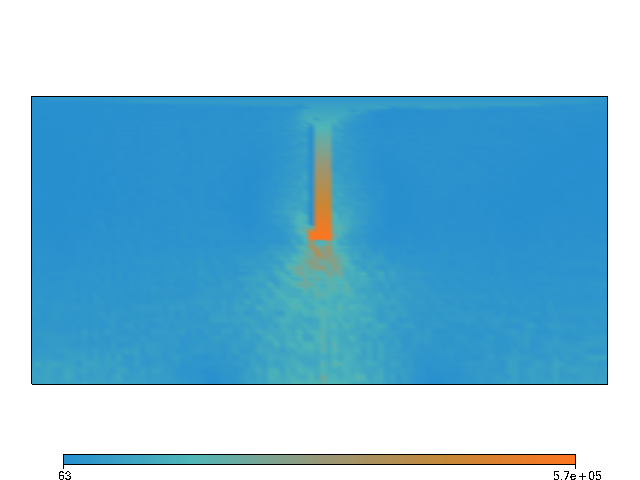

In [55]:
figTemp = glucifer.Figure()
figTemp.append( glucifer.objects.Surface(mesh, fn.tensor.second_invariant(fn_stress)))
#figTemp.append( glucifer.objects.VectorArrows(mesh,velocityField, arrowHead=0.2, scaling=0.0005))

figTemp.show()

Create an advective-diffusive system
=====

Setup the system in underworld by flagging the temperature and velocity field variables.

In [56]:
#Create advdiff system

advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = 1.0, 
                                         conditions     = [tempBC,] )



advector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

#Switch particle escape on, this will also trigger the inflow population control 
gSwarm.particleEscape = True

Metrics for benchmark
=====

Define functions to be used in the time loop. For cases 1-4, participants were asked to report a number of diagnostic quantities to be measured after reaching steady state:

* Average temp... $$  \langle T \rangle  = \int^1_0 \int^1_0 T \, dxdy $$
* Top and bottom Nusselt numbers... $$N = \int^1_0 \frac{\partial T}{\partial y} \rvert_{y=0/1} \, dx$$
* RMS velocity over the whole domain, surface and max velocity at surface
* max and min viscosity over the whole domain
* average rate of work done against gravity...$$\langle W \rangle = \int^1_0 \int^1_0 T u_y \, dx dy$$
* and the average rate of viscous dissipation...$$\langle \Phi \rangle = \int^1_0 \int^1_0 \tau_{ij} \dot \epsilon_{ij} \, dx dy$$

* In steady state, if thermal energy is accurately conserved, the difference between $\langle W \rangle$ and $\langle \Phi \rangle / Ra$ must vanish, so also reported is the percentage error: 

$$ \delta = \frac{\lvert \langle W \rangle - \frac{\langle \Phi \rangle}{Ra} \rvert}{max \left(  \langle W \rangle,  \frac{\langle \Phi \rangle}{Ra}\right)} \times 100% $$

In [91]:
#Setup some Integrals. We want these outside the main loop...
tempVariable = gSwarm.add_variable( dataType="double", count=1 )
tempVariable.data[:] = temperatureField.evaluate(gSwarm)[:]
tempint = uw.utils.Integral((tempVariable*rockIntVar), mesh)


areaint = uw.utils.Integral((1.*rockIntVar),mesh)

v2int = uw.utils.Integral(fn.math.dot(velocityField,velocityField)*rockIntVar, mesh)


dwint = uw.utils.Integral(temperatureField*velocityField[1]*rockIntVar, mesh)


sinner = fn.math.dot(strainRate_2ndInvariant,strainRate_2ndInvariant)
vdint = uw.utils.Integral((4.*viscosityMapFn*sinner)*rockIntVar, mesh)
vdintair = uw.utils.Integral((4.*viscosityMapFn*sinner)*airIntVar, mesh)
vdintlith = uw.utils.Integral((4.*viscosityMapFn*sinner)*lithIntVar, mesh)

In [92]:
#These should differ if the the map function assigns different properties to bulk mantle

print(uw.utils.Integral((4.*mantleviscosityFn*sinner)*rockIntVar, mesh).evaluate()[0])
print(uw.utils.Integral((4.*viscosityMapFn*sinner)*rockIntVar, mesh).evaluate()[0])

print(uw.utils.Integral((4.*mantleviscosityFn*sinner)*airIntVar, mesh).evaluate()[0])
print(uw.utils.Integral((4.*viscosityMapFn*sinner)*airIntVar, mesh).evaluate()[0])

print(uw.utils.Integral((4.*mantleviscosityFn*sinner)*lithIntVar, mesh).evaluate()[0])
print(uw.utils.Integral((4.*viscosityMapFn*sinner)*lithIntVar, mesh).evaluate()[0])

468713465.736
449043769.963
0.0
0.0
31629681.2154
11959985.4425


In [59]:
def avg_temp():
    return tempint.evaluate()[0]/areaint.evaluate()[0]

#This one gets cleaned up when Surface integrals are available
def nusselt(tempfield, swarm, dx):
    #Update the swarm variable
    tempgrad = tempfield.fn_gradient
    valcheck = tempgrad[1].evaluate(swarm)
    if valcheck is None:
        vals = np.array(0, dtype='float64')
    else:
        vals = valcheck.sum()*dx
    return vals

def rms():
    return math.sqrt(v2int.evaluate()[0]/areaint.evaluate()[0])

#This one gets cleaned up when Surface integrals are available
def rms_surf(swarm, dx):
    rmsmaxfn = fn.math.dot(velocityField,velocityField)
    rmscheck = rmsmaxfn.evaluate(swarm)
    if rmscheck is None:
        #print "watch out"
        rmsvals = np.array(0, dtype='float64')
    else:
        rmsvals = np.sqrt(rmscheck.sum()*dx)
        #print "okay"
    return rmsvals

def max_vx_surf(velfield, swarm):
    check = velfield[0].evaluate(swarm)
    if check is None:
        return 0.
    else:
        return check.max()


#def max_vy_surf(velfield, swarm):
#    surfvelxmaxfn = fn.view.min_max(velfield[1])
#    surfvelxmaxfn.evaluate(swarm)
#    return surfvelxmaxfn.max_global()

def gravwork(workfn):
    return workfn.evaluate()[0]

def viscdis(vdissfn):
    return vdissfn.evaluate()[0]

def visc_extr(viscfn):
    vuviscfn = fn.view.min_max(viscfn)
    vuviscfn.evaluate(gSwarm)
    return vuviscfn.max_global(), vuviscfn.min_global()

In [60]:
#Fields for saving data / fields

rmsField = uw.mesh.MeshVariable( mesh=mesh,   nodeDofCount=1)
rmsfn = fn.math.sqrt(fn.math.dot(velocityField,velocityField))
rmsdata = rmsfn.evaluate(mesh)
rmsField.data[:] = rmsdata 

viscField = uw.mesh.MeshVariable( mesh=mesh,   nodeDofCount=1)
viscdata = mantleviscosityFn.evaluate(mesh)
viscField.data[:] = viscdata


strainrateField = uw.mesh.MeshVariable( mesh=mesh,   nodeDofCount=1)
srtdata = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.fn_gradient ))
rostfield = srtdata.evaluate(mesh)
strainrateField.data[:] = rostfield

viscVariable = gSwarm.add_variable( dataType="float", count=1 )
viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)

In [61]:
#Images
figEta = glucifer.Figure()
figEta.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True))


figMat = glucifer.Figure()
figMat.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red'))
figMat.append( glucifer.objects.Mesh(mesh))


figStrainRate = glucifer.Figure()
figStrainRate.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True))


figVelocityMag = glucifer.Figure()
figVelocityMag.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField,velocityField))
)
figTemp = glucifer.Figure()
figTemp.append( glucifer.objects.Surface(mesh, temperatureField))



#Pack some stuff into a database as well
figDb = glucifer.Figure()
figDb.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True, colours='brown white blue'))
figDb.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red'))
figDb.append( glucifer.objects.Mesh(mesh))
figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, arrowHead=0.2, scaling=0.002))
figDb.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True, colours='brown white blue'))
figDb.append( glucifer.objects.Surface(mesh, temperatureField))

Main simulation loop
=======

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.


In [62]:
pics = uw.swarm.PICIntegrationSwarm(gSwarm)

In [63]:
def checkpoint1(step, checkpointPath,filename, filewrites):
    path = checkpointPath + str(step) 
    os.mkdir(path)
    ##Write and save the file, if not already a writing step
    if not step % filewrites == 0:
        filename.write((13*'%-15s ' + '\n') % (realtime, Viscdis, float(Nu0glob), float(Nu1glob), Avg_temp, 
                                              Rms,Rmsurfglob,Max_vx_surf,Gravwork, etamax, etamin, Viscdisair, Viscdislith))
    filename.close()
    shutil.copyfile(os.path.join(outputPath, outputFile), os.path.join(path, outputFile))


def checkpoint2(step, checkpointPath, swarm, filename, varlist = [materialVariable], varnames = ['materialVariable']):
    path = checkpointPath + str(step) 
    velfile = "velocityField" + ".hdf5"
    tempfile = "temperatureField" + ".hdf5"
    pressfile = "pressureField" + ".hdf5"
    velocityField.save(os.path.join(path, velfile))
    temperatureField.save(os.path.join(path, tempfile))
    pressureField.save(os.path.join(path, pressfile))
    swarm.save(os.path.join(path, "swarm.h5") ) 
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.save(os.path.join(path,varnames[ix] + ".h5"))
    

In [64]:
advector.get_max_dt(), advDiff.get_max_dt()

(1.1371883207028284e-06, 5.685941603514142e-07)

In [67]:
# initialise timer for computation
start = time.clock()
# setup summary output file (name above)
if checkpointLoad:
    if uw.rank() == 0:
        shutil.copyfile(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    comm.Barrier()
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    if len(prevdata.shape) == 1: #this is in case there is only one line in previous file
        realtime = prevdata[0]
    else:
        realtime = prevdata[prevdata.shape[0]-1, 0]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]

In [95]:
# initialise timer for computation
startMain = time.clock()
# Perform steps
#while realtime < 0.05:
while step < 5:
    #Enter non-linear loop
    print step
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    #start = time.clock()
    advDiff.integrate(dt)
    #machine_time = (time.clock()-start)
    #print("total advDiff time is: " + str(machine_time))
    # Advect swarm using this timestep size
    #start = time.clock()
    advector.integrate(dt)
    #machine_time = (time.clock()-start)
    #print("total advector time is: " + str(machine_time))
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    
    ################
    #Update temperature field in the air region
    ################
    if (step % sticky_air_temp == 0):
        for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = 0.
 
    ################
    #Particle update
    ###############
    if (step % swarm_update == 0) or (step % metric_output == 0): #These updates should be done before any metric output
        #These swarm variables get updated first, as they are used to determine material changes
        particledepths = 1. - gSwarm.particleCoordinates.data[:,1]
        particletemps = temperatureField.evaluate(gSwarm)[:,0]
        conditionmap['depthcondition']['data'] = particledepths
        conditionmap['avgtempcondition']['data'] = particletemps
        ################
        number_updated = 0
        for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
            check = update_swarm(DG, particleID)
            if check > -1:
                number_updated += 1
                #if check == 0:
                #    print "from " + str(materialVariable.data[particleID]) + " to " + str(check)
                materialVariable.data[particleID] = check
            else:
                pass
        #Also update those integration swarms
        rockIntVar.data[:] = 0.
        notair = np.where(materialVariable.data != airIndex)
        rockIntVar.data[notair] = 1.
        airIntVar.data[:] = 0.
        notrock = np.where(materialVariable.data == airIndex)
        airIntVar.data[notrock] = 1.
        lithIntVar.data[:] = 0.
        islith = np.where((materialVariable.data == lithosphereIndex) | (materialVariable.data == crustIndex))
        lithIntVar.data[islith] = 1.

    ################            
    # Calculate the Metrics, only on 1 of the processors:
    ################
    if (step % metric_output == 0):
        ###############
        #Swarm - based Metrics
        ###############
        tempVariable.data[:] = temperatureField.evaluate(gSwarm)[:]
        Avg_temp = avg_temp()
        Rms = rms()
        Gravwork = gravwork(dwint)
        Viscdis = viscdis(vdint)
        Viscdisair = viscdis(vdintair)
        Viscdislith = viscdis(vdintlith)
        etamax, etamin = visc_extr(viscosityMapFn)
        #These are the ones that need mpi4py treatment
        Nu0loc = nusselt(temperatureField, baseintswarm, dx)
        Nu1loc = nusselt(temperatureField, surfintswarm, dx)
        Rmsurfloc = rms_surf(surfintswarm, dx)
        Max_vx_surfloc = np.array(max_vx_surf(velocityField, surfintswarm),'d') #This float needed to be an array to play with mpi4py
        #Setup the global output arrays
        dTp = Nu0loc.dtype
        Nu0glob = np.array(0, dtype=dTp)
        dTp = Nu1loc.dtype
        Nu1glob = np.array(0, dtype=dTp)
        dTp = Rmsurfloc.dtype
        Rmsurfglob = np.array(0, dtype=dTp)
        dTp = Max_vx_surfloc.dtype
        Max_vx_surfglob = np.array(0.0,dtype=dTp)   
        #Do global operation ... sum, or max
        comm.Allreduce(Nu0loc, Nu0glob, op=MPI.SUM)
        comm.Allreduce(Nu1loc, Nu1glob, op=MPI.SUM)
        comm.Allreduce(Rmsurfloc, Rmsurfglob, op=MPI.SUM)
        comm.Allreduce([Max_vx_surfloc, MPI.DOUBLE],[Max_vx_surfglob, MPI.DOUBLE],op=MPI.MAX)      
        # output to summary text file
        if uw.rank()==0:
            f_o.write((13*'%-15s ' + '\n') % (realtime, Viscdis, float(Nu0glob), float(Nu1glob), Avg_temp, 
                                              Rms,Rmsurfglob,Max_vx_surfglob,Gravwork, etamax, etamin, Viscdisair, Viscdislith))
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0) & (writeFiles == True):
        #Rebuild any necessary swarm variables
        viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)
        #Write gldbs
        fnamedb = "dbFig" + "_" + str(ModIt) + "_" + str(step) + ".gldb"
        fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
        figDb.show()
        figDb.save_database(fullpath)
    ################
    #Also repopulate entire swarm periodically
    ################
    if step % swarm_repop == 0:
        pics.repopulate()
    ################
    #Checkpoint
    ################
    if step % checkpoint_every == 0:
        if uw.rank() == 0:
            checkpoint1(step, checkpointPath,f_o, metric_output)           
        checkpoint2(step, checkpointPath, gSwarm, f_o, varlist = varlist, varnames = varnames)
        f_o = open(os.path.join(outputPath, outputFile), 'a') #is this line supposed to be here?

        
        
f_o.close()
print 'step =',step

1
2
3
4
step = 5


In [ ]:
figTemp = glucifer.Figure()
figTemp.append( glucifer.objects.Surface(mesh, temperatureField))
figTemp.append( glucifer.objects.Mesh(mesh))

figTemp.append( glucifer.objects.VectorArrows(mesh,velocityField, arrowHead=0.2, scaling=0.01))
figTemp.save_database('test.gldb')
figTemp.show()

In [ ]:
#figVelocityMag = glucifer.Figure(figsize=(1024,384))
#figVelocityMag.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField,velocityField), logScale=True))
#figVelocityMag.show()

In [ ]:
#figVelocityMag = glucifer.Figure(figsize=(1024,384))
#figVelocityMag.append( glucifer.objects.Surface(mesh, temperatureField, logScale=True, valueRange=[1e-15,5e-8]) )
#figVelocityMag.show()

In [ ]:
#figVelocityMag


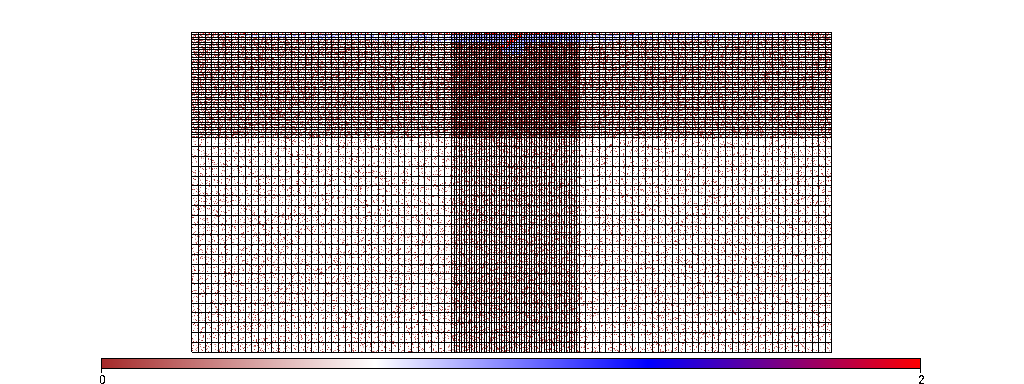

In [67]:
#figSwarm = glucifer.Figure(figsize=(1024,384))
#figSwarm.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red'))
#figSwarm.append( glucifer.objects.Mesh(mesh))
#figSwarm.show()
#figSwarm.save_database('test.gldb')

In [53]:
machine_time = (time.clock()-start)
print("total time is: " + str(machine_time))

NameError: name 'start' is not defined

In [54]:
#Sanity check for periodic conditions
#velocityField.evaluate(TWalls)[:,0].max()

1100.5338620296968

In [31]:
#print("TWalls x vel is: " + str(velocityField.evaluate(TWalls)[:,0].max()))
#print("IWalls x vel is: " + str(velocityField.evaluate(IWalls)[:,0].max()))


TWalls x vel is: 3.17721915245
IWalls x vel is: -0.143166437745


In [ ]:
#ts = ((D*1e3)**2)/k
#secperyear = (3600*24*365)
#dt*ts/secperyear

#2.25895987733e-05*ts/secperyear